In [292]:
import io
import re
import pandas as pd
import matplotlib.pyplot as plt
import chess
import chess.pgn
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
import seaborn as sns



In [293]:
ogdf = pd.read_csv('club_games_data.csv')

In [294]:
df = ogdf.copy()

## Making data

In [295]:
def count_pawn_moves(pgn_str):
    pgn = chess.pgn.read_game(io.StringIO(pgn_str))
    board = pgn.board()
    pawn_moves = {'White': [0]*8, 'Black': [0]*8}
    for move in pgn.mainline_moves():
        board.push(move)
        rank = chess.square_rank(move.to_square)
        moved_piece = board.piece_at(move.to_square)
        if not moved_piece:
            return{'White': 0, 'Black': 0} 
        if moved_piece.piece_type == chess.PAWN:
            if moved_piece.color == chess.WHITE:
                pawn_moves['White'][rank] += 1
            else:
                pawn_moves['Black'][rank] += 1
    return pawn_moves

In [296]:
df[['black_pawn_moves', 'white_pawn_moves']] = ogdf.apply(lambda row: pd.Series(count_pawn_moves(row['pgn'])), axis=1)

In [297]:
df['white_win'] = df.apply(lambda row: 1 if row['white_result'] == 'win' else 0, axis=1)
df['black_win'] = df.apply(lambda row: 1 if row['black_result'] == 'win' else 0, axis=1)


In [298]:
df['white_simple_result']=df.apply(lambda row: 'win' if row['white_result'] == 'win' else 'loss' if row['black_result']=='win' else 'draw', axis=1)
df['black_simple_result']=df.apply(lambda row: 'win' if row['black_result'] == 'win' else 'loss' if row['white_result']=='win' else 'draw', axis=1)

In [309]:
df['Elo_class'] = pd.cut(df['white_rating'], bins=[0, 500, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2300, 2400, 2500, 2700, 3100], labels=[
                         '<500', '500-1000', '1000-1200', '1200-1400', '1400-1600', '1600-1800', '1800-2000', '2000-2200', '2200-2300', '2300-2400', '2400-2500', '2500-2700', '2700-3000'])

df['sum_white_pawn_moves'] = df['white_pawn_moves'].apply(lambda x: sum(x))

df['sum_black_pawn_moves'] = df['black_pawn_moves'].apply(lambda x: sum(x))

df['sum_pawn_moves'] = df['sum_white_pawn_moves'] + df['sum_black_pawn_moves']



In [299]:
df.head()

,white_username,black_username,white_id,black_id,white_rating,black_rating,white_result,black_result,time_class,time_control,rules,rated,fen,pgn,black_pawn_moves,white_pawn_moves,white_win,black_win,white_simple_result,black_simple_result
0,-Amos-,miniman2804,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/miniman2804,1708,1608,win,checkmated,daily,1/259200,chess,True,r2r4/p2p1p1p/b6R/n1p1kp2/2P2P2/3BP3/PP5P/4K2R ...,"[Event ""Enjoyable games 2 - Round 1""]\n[Site ""...","[0, 0, 1, 4, 2, 0, 0, 0]","[0, 0, 0, 0, 4, 3, 0, 0]",1,0,win,loss
1,-Amos-,koltcho69,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/koltcho69,1726,1577,win,resigned,daily,1/172800,chess,True,8/5Q1k/4n1pp/8/7P/2N2b2/PP3P2/5K2 b - - 1 33,"[Event ""Rapid Rats - Board 5""]\n[Site ""Chess.c...","[0, 0, 1, 4, 2, 1, 1, 0]","[0, 0, 0, 1, 4, 5, 0, 0]",1,0,win,loss
2,-Amos-,enhmandah,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/enhmandah,1727,842,win,resigned,daily,1/172800,chess,True,rn1q1b1r/kb2p1pp/2p5/p1Q5/N1BP2n1/4PN2/1P3PPP/...,"[Event ""CHESS BOARD CLASH - Round 1""]\n[Site ""...","[0, 0, 1, 3, 0, 0, 0, 0]","[0, 0, 0, 2, 3, 1, 0, 0]",1,0,win,loss
3,enhmandah,-Amos-,https://api.chess.com/pub/player/enhmandah,https://api.chess.com/pub/player/-amos-,819,1727,checkmated,win,daily,1/172800,chess,True,r3kb1r/pp3ppp/3p1n2/2pKp3/P3P3/1P6/4qP1P/QNB5 ...,"[Event ""CHESS BOARD CLASH - Round 1""]\n[Site ""...","[0, 0, 2, 2, 0, 0, 0, 0]","[0, 0, 0, 0, 2, 1, 0, 0]",0,1,loss,win
4,-Amos-,Shalllow-Blue,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/shalllow-blue,1729,1116,win,resigned,daily,1/172800,chess,True,r3b2r/pp6/2pPpR1k/4n3/2P3Q1/3B4/PP4PP/R5K1 b -...,"[Event ""CHESS BOARD CLASH - Round 1""]\n[Site ""...","[0, 0, 1, 4, 3, 2, 0, 0]","[0, 0, 0, 1, 1, 5, 0, 0]",1,0,win,loss


## Cleaning Data


In [300]:
df = df[df['rules'] == 'chess']  # remove non-chess games
df = df[df["pgn"].apply(lambda pgn: chess.pgn.read_game(
    io.StringIO(pgn)).mainline_moves() != None)]  # remove games with no moves


In [301]:
df = df[df["pgn"].apply(lambda pgn: "Endgame" not in chess.pgn.read_game(
    io.StringIO(pgn)).headers["Event"])]  # remove endgame puzzles


In [302]:
for index, row in df.iterrows():  # remove abandoned games
    pgn = row["pgn"]
    game = chess.pgn.read_game(io.StringIO(pgn))
    start_time = game.headers["StartTime"]
    end_time = game.headers["EndTime"]
    if start_time == end_time:
        df.drop(index, inplace=True)


In [310]:
df = df[df['sum_pawn_moves']!=0]

In [353]:
df = df[df['black_result'] != 'abandoned']
df = df[df['white_result'] != 'abandoned']

In [311]:
df.head()

,white_username,black_username,white_id,black_id,white_rating,black_rating,white_result,black_result,time_class,time_control,...,black_pawn_moves,white_pawn_moves,white_win,black_win,white_simple_result,black_simple_result,Elo_class,sum_white_pawn_moves,sum_black_pawn_moves,sum_pawn_moves
0,-Amos-,miniman2804,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/miniman2804,1708,1608,win,checkmated,daily,1/259200,...,"[0, 0, 1, 4, 2, 0, 0, 0]","[0, 0, 0, 0, 4, 3, 0, 0]",1,0,win,loss,1600-1800,7,7,14
1,-Amos-,koltcho69,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/koltcho69,1726,1577,win,resigned,daily,1/172800,...,"[0, 0, 1, 4, 2, 1, 1, 0]","[0, 0, 0, 1, 4, 5, 0, 0]",1,0,win,loss,1600-1800,10,9,19
2,-Amos-,enhmandah,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/enhmandah,1727,842,win,resigned,daily,1/172800,...,"[0, 0, 1, 3, 0, 0, 0, 0]","[0, 0, 0, 2, 3, 1, 0, 0]",1,0,win,loss,1600-1800,6,4,10
3,enhmandah,-Amos-,https://api.chess.com/pub/player/enhmandah,https://api.chess.com/pub/player/-amos-,819,1727,checkmated,win,daily,1/172800,...,"[0, 0, 2, 2, 0, 0, 0, 0]","[0, 0, 0, 0, 2, 1, 0, 0]",0,1,loss,win,500-1000,3,4,7
4,-Amos-,Shalllow-Blue,https://api.chess.com/pub/player/-amos-,https://api.chess.com/pub/player/shalllow-blue,1729,1116,win,resigned,daily,1/172800,...,"[0, 0, 1, 4, 3, 2, 0, 0]","[0, 0, 0, 1, 1, 5, 0, 0]",1,0,win,loss,1600-1800,7,10,17


## Logistic regression analysis on the relationship between pawn moves in each rank and winning

For white:

In [328]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_wins = df['white_win'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_wins, test_size=0.2, random_state=42)

w_model = LogisticRegression()

w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)

yw_pred_proba = w_model.predict_proba(Xw_test)[:, 1]

print('accuracy: ', accuracy_score(yw_test, w_pred))
print('ROC AUC: ', roc_auc_score(yw_test, yw_pred_proba))

accuracy:  0.5511376695012641
ROC AUC:  0.5773343240552926


For black:

In [327]:
black_pawn_moves = df['black_pawn_moves'].tolist()
black_wins = df['black_win'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
     black_pawn_moves, black_wins, test_size=0.2, random_state=42)

b_model = LogisticRegression()

b_model.fit(Xb_train, yb_train)

b_pred = b_model.predict(Xb_test)
yb_pred_proba = b_model.predict_proba(Xb_test)[:, 1]

print('accuracy: ', accuracy_score(yb_test, b_pred))
print('ROC AUC: ', roc_auc_score(yb_test, yb_pred_proba))

accuracy:  0.5666896498889145
ROC AUC:  0.5965605516514266


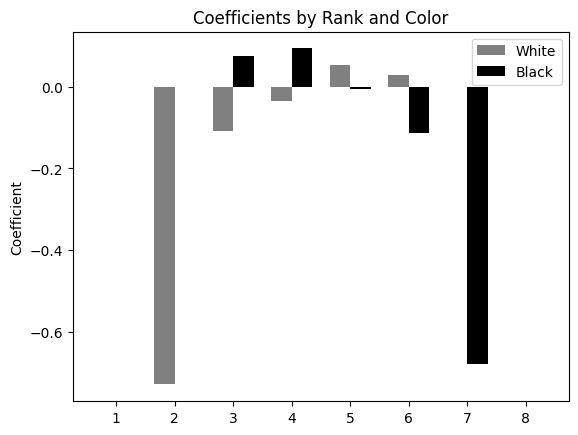

In [329]:
w_coefs = w_model.coef_.ravel()
b_coefs = b_model.coef_.ravel()

# Set the x positions of the bars
bar_width = 0.35
white_pos = np.arange(8)
black_pos = white_pos + bar_width

# Plot the bars
fig, ax = plt.subplots()
white_bars = ax.bar(white_pos, w_coefs, width=bar_width, label='White', color='grey')
black_bars = ax.bar(black_pos, b_coefs, width=bar_width, label='Black', color='black')

ax.set_ylabel('Coefficient')
ax.set_title('Coefficients by Rank and Color')
ax.set_xticks(white_pos + bar_width / 2)
ax.set_xticklabels(range(1,9))
ax.legend()

# Display the chart
plt.show()


In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(yw_test, yw_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for white')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(yb_test, yb_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for black')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(yw_test, yw_pred_proba)

# plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for white')
plt.show()

In [ ]:
# calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(yb_test, yb_pred_proba)

# plot precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for black')

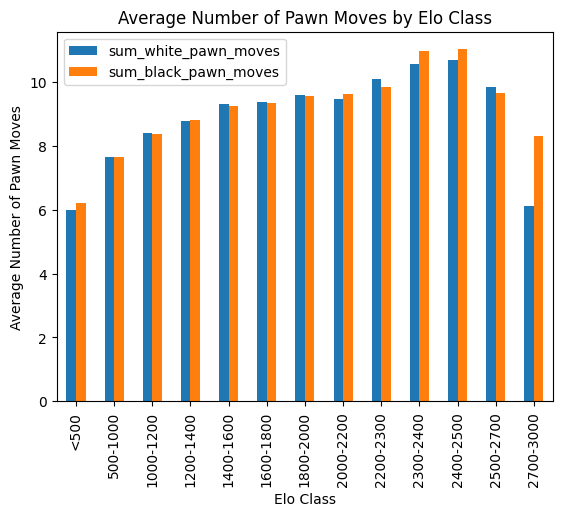

## Multinomial logistic regression analysis of pawn moves by rank against game result

/home/anton/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


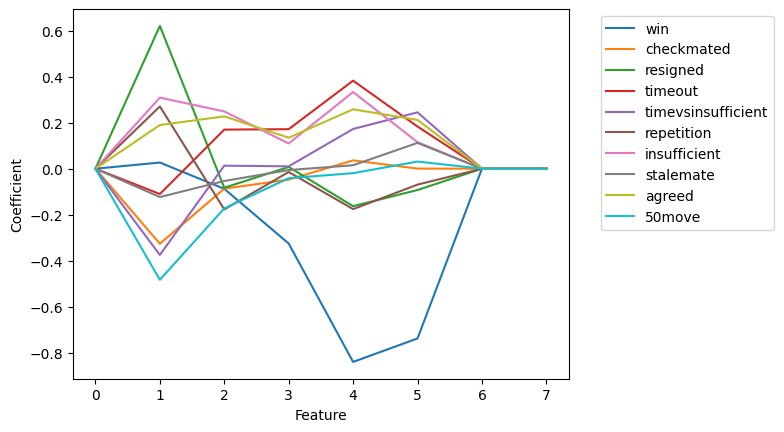

In [377]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_results = df['white_result'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_results, test_size=0.2, random_state=42)

w_model = LogisticRegression(multi_class='multinomial')
w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)
w_pred_proba = w_model.predict_proba(Xw_test)[:, 1]

coeffs = w_model.coef_
game_results = df['white_result'].unique()

fig, ax = plt.subplots()
for i in range(coeffs.shape[0]):
    ax.plot(coeffs[i], label=game_results[i])

ax.set_xlabel('Feature')
ax.set_ylabel('Coefficient')
ax.legend(bbox_to_anchor=(1.05,1))

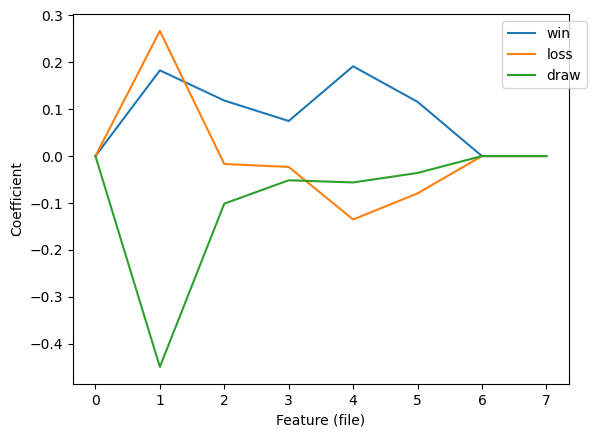

In [357]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_simple_results = df['white_simple_result'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_simple_results, test_size=0.2, random_state=42)

w_model = LogisticRegression(multi_class='multinomial')
w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)
w_pred_proba = w_model.predict_proba(Xw_test)[:, 1]

coeffs = w_model.coef_
game_results = df['white_simple_result'].unique()

# plot the coefficients for each class
fig, ax = plt.subplots()
for i in range(coeffs.shape[0]):
    ax.plot(coeffs[i], label=game_results[i])

ax.set_xlabel('Feature (file)')
ax.set_ylabel('Coefficient')
ax.legend(bbox_to_anchor=(1.05,1))

## Random forrest classifier

For white:

0.4864562524970036


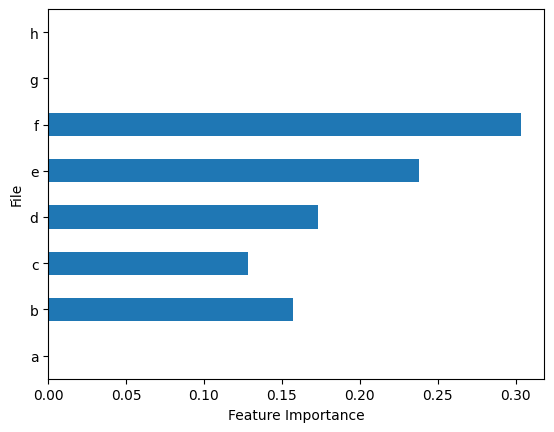

In [372]:
white_pawn_moves = df['white_pawn_moves'].tolist()
white_results = df['white_result'].tolist()

Xw_train, Xw_test, yw_train, yw_test = train_test_split(
     white_pawn_moves, white_results, test_size=0.2, random_state=42)

w_model = RandomForestClassifier()
w_model.fit(Xw_train, yw_train)

w_pred = w_model.predict(Xw_test)
yw_pred_proba = w_model.predict_proba(Xw_test)[:, 1]

print(accuracy_score(yw_test, w_pred))
# print('ROC AUC: ', roc_auc_score(yw_test, yw_pred_proba))

# plot feature importances
importances = pd.Series(w_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

accuracy:  0.4663204155013983


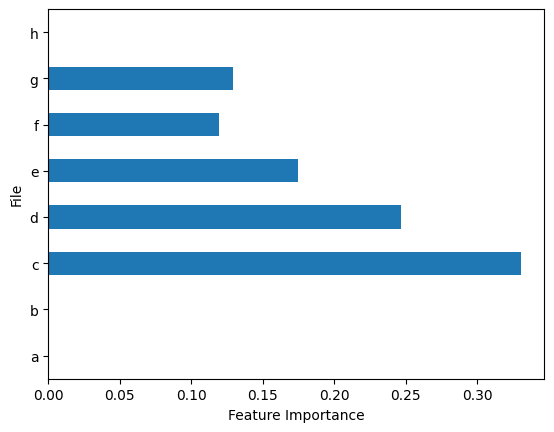

In [373]:
jblack_pawn_moves = df['black_pawn_moves'].tolist()
black_results = df['black_result'].tolist()

Xb_train, Xb_test, yb_train, yb_test = train_test_split(
     black_pawn_moves, black_results, test_size=0.2, random_state=42)

b_model = RandomForestClassifier()

b_model.fit(Xb_train, yb_train)

b_pred = b_model.predict(Xb_test)
yb_pred_proba = b_model.predict_proba(Xb_test)[:, 1]

print('accuracy: ', accuracy_score(yb_test, b_pred))
# print('ROC AUC: ', roc_auc_score(yb_test, yb_pred_proba))

# plot feature importances
importances = pd.Series(b_model.feature_importances_, index=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
importances.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.ylabel('File')
plt.show()

In [374]:
# Calculate ROC curve and ROC AUC score
fpr, tpr, thresholds = roc_curve(yw_test, w_pred, pos_label='win')
roc_auc = roc_auc_score(yw_test, w_pred)

# Create ROC curve plot
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

plt.show()

UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U18'), dtype('<U18')) -> None

 ## Misc.

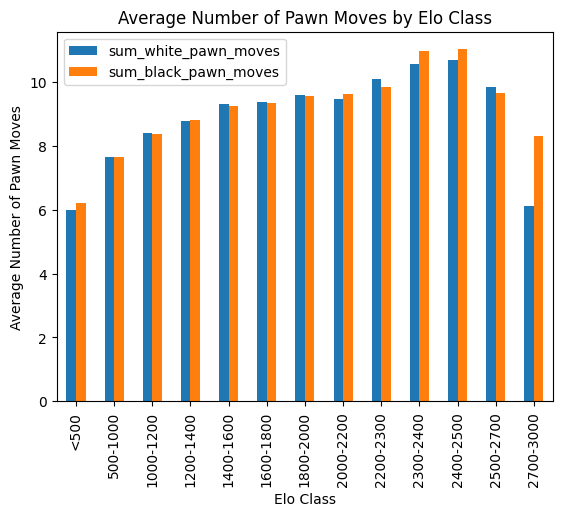

In [330]:
# Calculate average number of pawn moves for each Elo class
pawn_moves_by_elo = df.groupby(
    'Elo_class')[['sum_white_pawn_moves', 'sum_black_pawn_moves']].mean()

# Plot bar graph
pawn_moves_by_elo.plot(kind='bar')
plt.xlabel('Elo Class')
plt.ylabel('Average Number of Pawn Moves')
plt.title('Average Number of Pawn Moves by Elo Class')
plt.show()
